<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 2

</h4>

# Personal Data

In [1]:
# Set your student number
student_number = 400101078
Name = 'Tina'
Last_Name = 'Halimi'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch. 

## Question 1) Convolutional Neural Networks ``(50 pt.)``

In this question, you'll be coding up a convolutional neural network from scratch to classify images using PyTorch.  

### Instructions
- Install PyTorch following the instructions [here](https://pytorch.org/).
- Install the [`torchinfo` package](https://github.com/TylerYep/torchinfo) to visualize the network architecture and the number of parameters. The maximum number of parameters you are allowed to use for your network is **100,000**. 
- You are required to complete the functions defined in the code blocks following each question. Fill out sections of the code marked `"YOUR CODE HERE"`.
- You're free to add any number of methods within each class.
- You may also add any number of additional code blocks that you deem necessary.

In [2]:
!pip install torchinfo


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


### Data Preparation
In this assignment, we will use the Fashion-MNIST dataset. Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.  

#### Data

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.  

#### Labels

Each training and test example is assigned to one of the following labels:

| Label | Description |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Fashion-MNIST is included in the `torchvision` library.

In [3]:
# Import required packages
import torch
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Transform to normalize the data and convert to a tensor
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
# Download the data
dataset = FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)

### Data Exploration
Let's take a look at the classes in our dataset.

In [5]:
print(dataset.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Now, visualize an instance from each class.

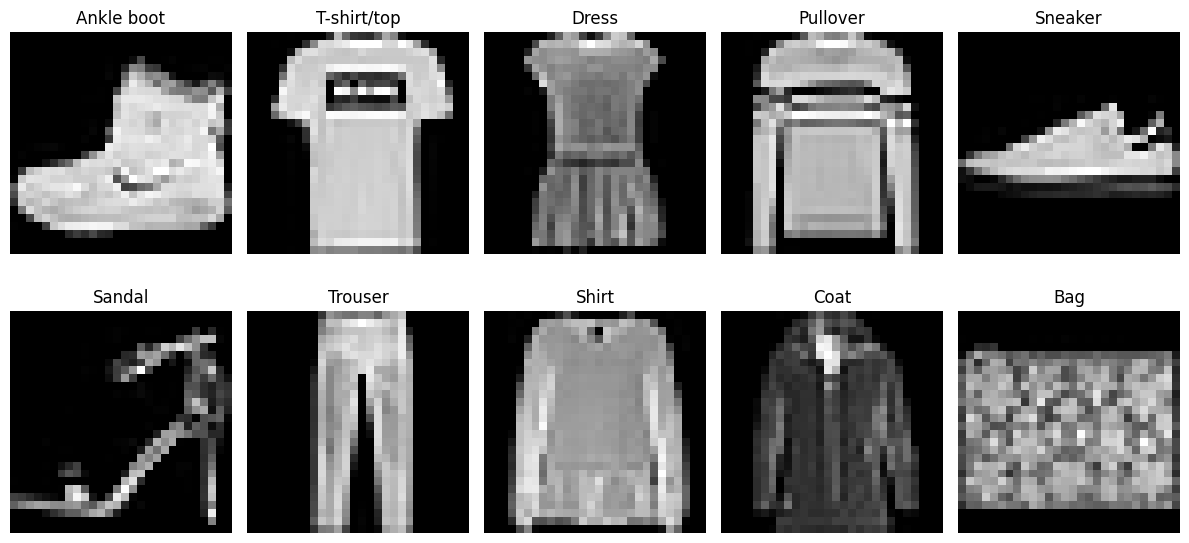

In [6]:
# Mapping of labels to class names

label_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

class_images = {}

# Iterate through the dataset to find one image per class
for img, label in dataset:
    if label not in class_images:
        class_images[label] = img
    if len(class_images) == 10:  # If we have found all classes, break the loop
        break

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for idx, (label, img) in enumerate(class_images.items()):
    axes[idx].imshow(img.squeeze(), cmap='gray')
    axes[idx].set_title(label_map[label])
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### Creating Training and Validation Datasets

The `split_indices` function takes in the size of the entire dataset, `n`, the fraction of data to be used as validation set, `val_frac`, and the random seed and returns the indices of the data points to be added to the validation dataset. 

In [7]:
def split_indices(n, val_frac, seed):
    # Determine the size of the validation set
    n_val = int(val_frac * n)
    np.random.seed(seed)
    # Create random permutation between 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [8]:
val_frac = 0.2 ## Set the fraction for the validation set
rand_seed = 42 ## Set the random seed

train_indices, val_indices = split_indices(len(dataset), val_frac, rand_seed)
print("number of samples in training set: {}".format(len(train_indices)))
print("number of samples in validation set: {}".format(len(val_indices)))

number of samples in training set: 48000
number of samples in validation set: 12000


Next, we make use of the built-in dataloaders in PyTorch to create iterables of our our training and validation sets. This helps in avoiding fitting the whole dataset into memory and only loads a batch of the data that we can decide. 

In [9]:
# Import required packages
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [10]:
batch_size = 64

train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                     batch_size,
                     sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                   batch_size,
                   sampler=val_sampler)

Plot images in a sample batch of data.

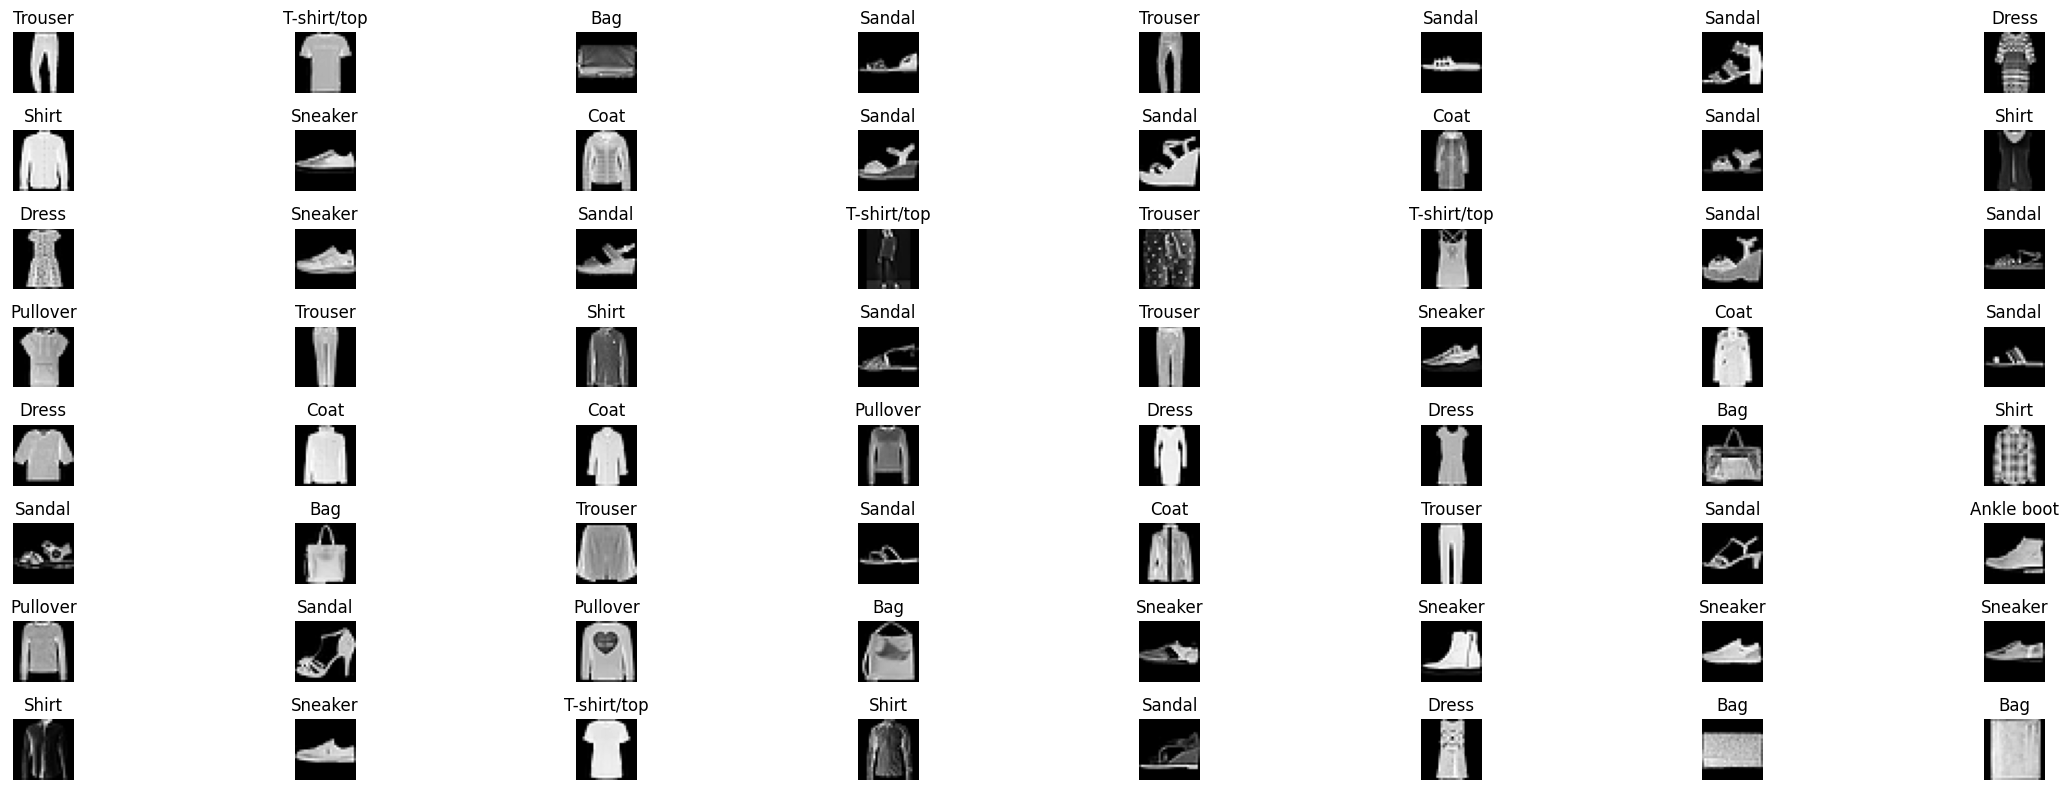

In [11]:
import matplotlib.pyplot as plt

# Function to plot all images in a batch
def plot_batch(batch_images, batch_labels, class_names, ncols=8, figsize=(24, 8)):
    nrows = (len(batch_images) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        if i < len(batch_images):
            ax.imshow(batch_images[i].permute(1, 2, 0).numpy().squeeze(), cmap='gray')
            ax.set_title(class_names[batch_labels[i].item()])
            ax.axis('off')
        else:
            ax.axis('off')  # Remove axes if no more images to plot
    plt.tight_layout()
    plt.show()

# Get a batch of data from the training dataloader
sample_batch = next(iter(train_dl))
sample_images, sample_labels = sample_batch

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plot_batch(sample_images, sample_labels, class_names)


### Building the Model
Create your model by defining the network architecture in the `ImageClassifierNet` class.<br>
**NOTE:** The number of parameters in your network must be $\leq$ 100,000.

In [12]:
# Import required packages
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [13]:

class ImageClassifierNet(nn.Module):
    def __init__(self, n_channels=1):
        super(ImageClassifierNet, self).__init__()
        
        # first layer
        self.conv1 = nn.Conv2d(in_channels=n_channels, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # second layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        # third layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        # Calculate the flattened dimension after convolutions
        self.flatten_dim = 64 * 3 * 3
        
        # Define the fully connected layers
        self.fc1 = nn.Linear(self.flatten_dim, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, X):
        # Apply first convolutional layer + activation + pooling
        X = self.pool(F.relu(self.conv1(X)))
        #print("After conv1: ", X.shape)
        
        # Apply second convolutional layer + activation + pooling
        X = self.pool(F.relu(self.conv2(X)))
        #print("After conv2: ", X.shape)
        
        # Apply third convolutional layer + activation + pooling
        X = self.pool(F.relu(self.conv3(X)))
        #print("After conv3: ", X.shape) 
        
        # Flatten the output from the convolutional layers
        X = X.view(-1, self.flatten_dim)
        #print("After flatten: ", X.shape)
        
        # Apply the first fully connected layer + activation
        X = F.relu(self.fc1(X))
        #print("After fc1: ", X.shape)
        
        # Apply the second fully connected layer (output layer)
        X = self.fc2(X)
        #print("After fc2: ", X.shape)
        
        return X


In [14]:
model = ImageClassifierNet()

The following code block prints your network architecture. It also shows the total number of parameters in your network (see `Total params`).  

**NOTE: The total number of parameters in your model should be <= 100,000.**

In [15]:
summary(model, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifierNet                       [64, 10]                  --
├─Conv2d: 1-1                            [64, 16, 28, 28]          160
├─MaxPool2d: 1-2                         [64, 16, 14, 14]          --
├─Conv2d: 1-3                            [64, 32, 14, 14]          4,640
├─MaxPool2d: 1-4                         [64, 32, 7, 7]            --
├─Conv2d: 1-5                            [64, 64, 7, 7]            18,496
├─MaxPool2d: 1-6                         [64, 64, 3, 3]            --
├─Linear: 1-7                            [64, 128]                 73,856
├─Linear: 1-8                            [64, 10]                  1,290
Total params: 98,442
Trainable params: 98,442
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 129.05
Input size (MB): 0.20
Forward/backward pass size (MB): 11.31
Params size (MB): 0.39
Estimated Total Size (MB): 11.90

### Train the model
Complete the `train_model` function to train your model on a dataset. Tune your network architecture and hyperparameters on the validation set.

In [16]:
def train_model(n_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr):
    """
    Trains the model on a dataset.
    
    Args:
        n_epochs: number of epochs
        model: ImageClassifierNet object
        train_dl: training dataloader
        val_dl: validation dataloader
        loss_fn: the loss function
        opt_fn: the optimizer
        lr: learning rate
    
    Returns:
        The trained model. 
        A tuple of (model, train_losses, val_losses, train_accuracies, val_accuracies)
    """
    # Record these values the end of each epoch
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    optimizer = opt_fn(model.parameters(), lr=lr)
    
    for epoch in range(n_epochs):
        model.train()  # Set the model to training mode
        
        train_loss = 0
        correct_train = 0
        total_train = 0
        
        for X, y in train_dl:
            optimizer.zero_grad()
            
            outputs = model(X)
            loss = loss_fn(outputs, y)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += y.size(0)
            correct_train += (predicted == y).sum().item()
        
        train_loss /= len(train_dl)
        train_accuracy = 100 * correct_train / total_train
        
        if len(val_dl) > 0:
            model.eval()  # Set the model to evaluation mode
            val_loss = 0
            correct_val = 0
            total_val = 0
            
            with torch.no_grad():
                for X, y in val_dl:
                    outputs = model(X)
                    loss = loss_fn(outputs, y)
                    
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total_val += y.size(0)
                    correct_val += (predicted == y).sum().item()
            
            val_loss /= len(val_dl)
            val_accuracy = 100 * correct_val / total_val
            
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
        else:
            val_loss = None
            val_accuracy = None

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # print(f"Epoch {epoch+1}/{n_epochs}, "
        #       f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
        #       f"Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")
        
        print(f"Epoch {epoch+1}/{n_epochs}, "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%", end="")
        
        if val_loss is not None:
            print(f", Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        else:
            print("")
    
    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [17]:
# Custom Cross-Entropy Loss Function
def custom_loss_fn(outputs, targets):
    # Convert targets to one-hot encoding
    targets_one_hot = torch.eye(10)[targets].to(outputs.device)
    log_softmax_outputs = F.log_softmax(outputs, dim=1)
    loss = -torch.sum(targets_one_hot * log_softmax_outputs) / targets.size(0)
    return loss

# Custom Stochastic Gradient Descent (SGD) Optimizer
class CustomSGD:
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr
    
    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()
    
    def step(self):
        for param in self.params:
            if param.grad is not None:
                param.data -= self.lr * param.grad

num_epochs = 12 # Number of training epochs
loss_fn = custom_loss_fn # Define the loss function
opt_fn = CustomSGD # Select an optimizer
lr = 0.05 # Set the learning rate

In [18]:
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(num_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr)

Epoch 1/12, Train Loss: 0.9261, Train Accuracy: 66.08%, Val Loss: 0.5029, Val Accuracy: 80.78%
Epoch 2/12, Train Loss: 0.4648, Train Accuracy: 82.78%, Val Loss: 0.4465, Val Accuracy: 83.28%
Epoch 3/12, Train Loss: 0.3828, Train Accuracy: 85.90%, Val Loss: 0.3571, Val Accuracy: 86.87%
Epoch 4/12, Train Loss: 0.3413, Train Accuracy: 87.31%, Val Loss: 0.3460, Val Accuracy: 87.17%
Epoch 5/12, Train Loss: 0.3139, Train Accuracy: 88.29%, Val Loss: 0.3270, Val Accuracy: 87.81%
Epoch 6/12, Train Loss: 0.2925, Train Accuracy: 89.05%, Val Loss: 0.3445, Val Accuracy: 87.18%
Epoch 7/12, Train Loss: 0.2761, Train Accuracy: 89.71%, Val Loss: 0.2784, Val Accuracy: 89.60%
Epoch 8/12, Train Loss: 0.2618, Train Accuracy: 90.19%, Val Loss: 0.2724, Val Accuracy: 89.94%
Epoch 9/12, Train Loss: 0.2494, Train Accuracy: 90.85%, Val Loss: 0.2760, Val Accuracy: 89.78%
Epoch 10/12, Train Loss: 0.2369, Train Accuracy: 91.22%, Val Loss: 0.2677, Val Accuracy: 89.99%
Epoch 11/12, Train Loss: 0.2281, Train Accuracy: 

### Plot loss and accuracy

In [19]:
def plot_accuracy(train_accuracies, val_accuracies):
    """Plot accuracies"""
    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracies, "-x")
    plt.plot(val_accuracies, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Training", "Validation"])
    plt.title("Accuracy vs. No. of epochs")

def plot_losses(train_losses, val_losses):
    """Plot losses"""
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, "-x")
    plt.plot(val_losses, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of Epochs")

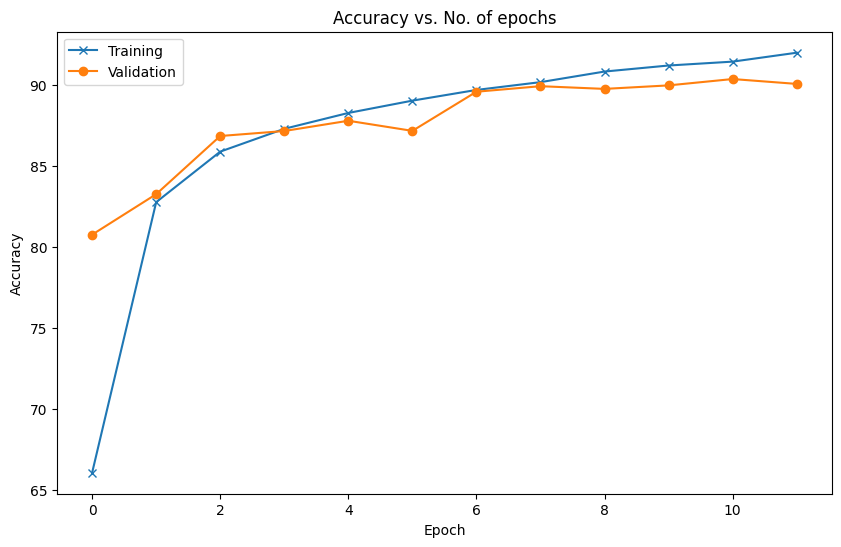

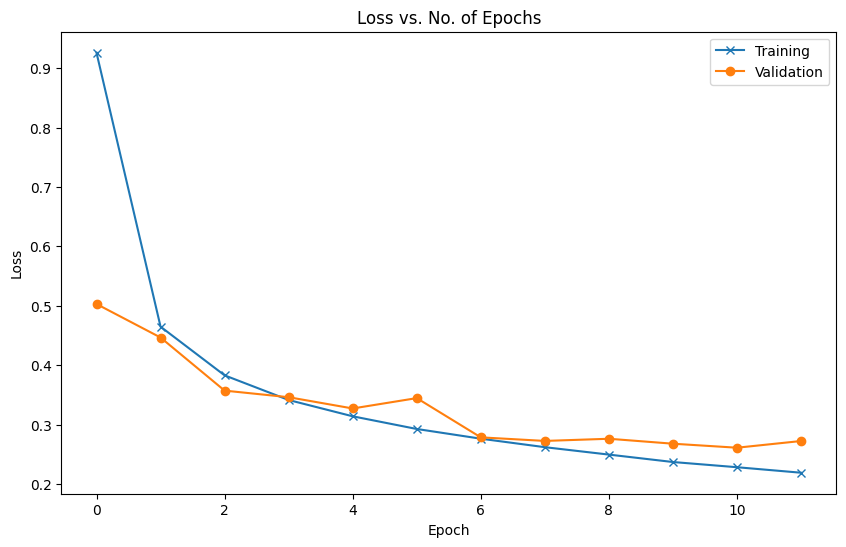

In [20]:
plot_accuracy(train_accuracies, val_accuracies)
plot_losses(train_losses, val_losses)

### Train a model on the entire dataset

In [21]:
indices, _ = split_indices(len(dataset), 0, rand_seed)

sampler = SubsetRandomSampler(indices)
dl = DataLoader(dataset, batch_size, sampler=sampler)

In [22]:
num_epochs = 15 # Max number of training epochs
lr = 0.05 # Set the learning rate

In [23]:
model, _, _, _, _ = train_model(num_epochs, model, dl, [], loss_fn, opt_fn, lr)

Epoch 1/15, Train Loss: 0.2211, Train Accuracy: 91.80%
Epoch 2/15, Train Loss: 0.2093, Train Accuracy: 92.18%
Epoch 3/15, Train Loss: 0.2010, Train Accuracy: 92.44%
Epoch 4/15, Train Loss: 0.1927, Train Accuracy: 92.81%
Epoch 5/15, Train Loss: 0.1843, Train Accuracy: 93.10%
Epoch 6/15, Train Loss: 0.1760, Train Accuracy: 93.46%
Epoch 7/15, Train Loss: 0.1695, Train Accuracy: 93.67%
Epoch 8/15, Train Loss: 0.1625, Train Accuracy: 93.89%
Epoch 9/15, Train Loss: 0.1558, Train Accuracy: 94.05%
Epoch 10/15, Train Loss: 0.1514, Train Accuracy: 94.28%
Epoch 11/15, Train Loss: 0.1424, Train Accuracy: 94.64%
Epoch 12/15, Train Loss: 0.1375, Train Accuracy: 94.91%
Epoch 13/15, Train Loss: 0.1312, Train Accuracy: 94.97%
Epoch 14/15, Train Loss: 0.1254, Train Accuracy: 95.27%
Epoch 15/15, Train Loss: 0.1188, Train Accuracy: 95.50%


### Check Predictions
Now, you should evaluate your model on dataset. Specifically, you should calculate the class probabilities for each image, and then visualize these probabilities along with the image itself. Please include a function `view_prediction` in your code that takes an image, its label, the calculated probabilities, and the list of class names as input, and plots the image along with the probabilities.

In [24]:
def view_prediction(image, label, probs):
    """
    Plots an image along with the class probabilities.
    
    Args:
        image: The image tensor
        label: The true label
        probs: The predicted probabilities
        class_names: List of class names
    """
    # Convert image tensor to numpy array for plotting
    image = image.squeeze().numpy()
    
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'True Label: {class_names[label]}')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    y_pos = np.arange(len(class_names))
    plt.barh(y_pos, probs)
    plt.yticks(y_pos, class_names)
    plt.xlabel('Probability')
    plt.title('Class Probabilities')
    plt.xlim(0, 1)
    
    plt.tight_layout()
    plt.show()


### Save the model

In [25]:
torch.save(model, 'model')

### Calculate accuracy on the test set

In [26]:
test_dataset = FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
test_dl = DataLoader(test_dataset, batch_size)

In [27]:
def evaluate(model, test_dl):
    """
    Evaluates your model on the test data.
    
    Args:
        model: ImageClassifierNet object
        test_dl: test dataloader
    
    Returns: 
        Test accuracy.
    """
    model.eval() 
    correct = 0
    total = 0
    images_so_far = 0
    num_images=5

    with torch.no_grad():
        for images, labels in test_dl:
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for i in range(images.size(0)):
                if images_so_far >= num_images:
                    break
                view_prediction(images[i], labels[i].item(), probabilities[i].cpu().numpy())
                images_so_far += 1
            if images_so_far >= num_images:
                break
    
    accuracy = 100 * correct / total
    return accuracy

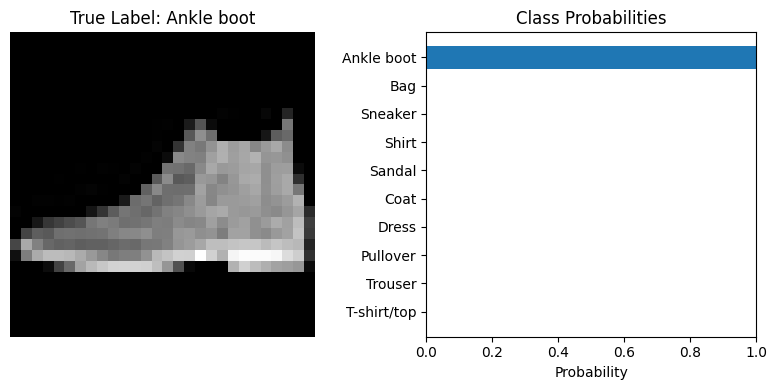

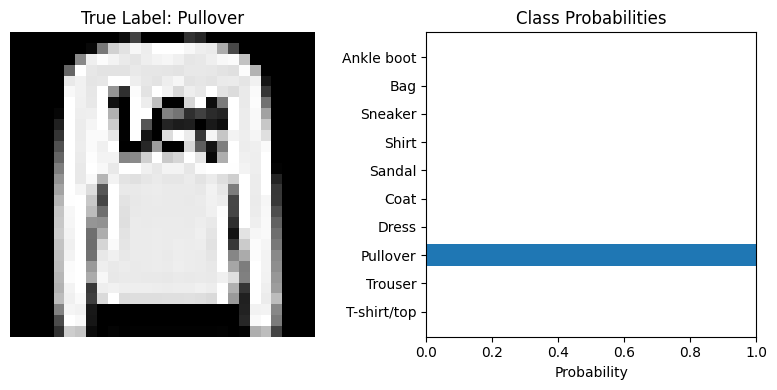

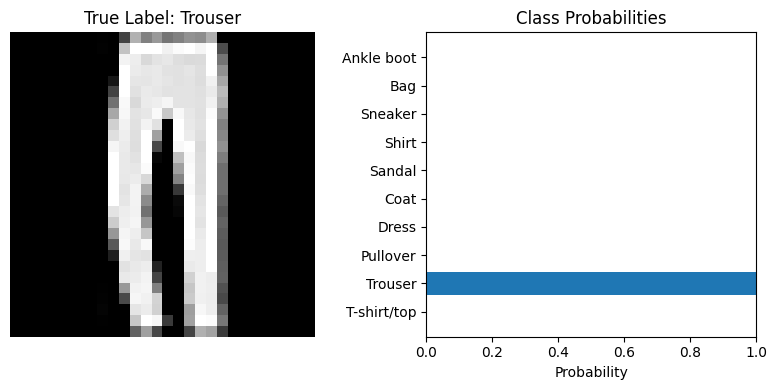

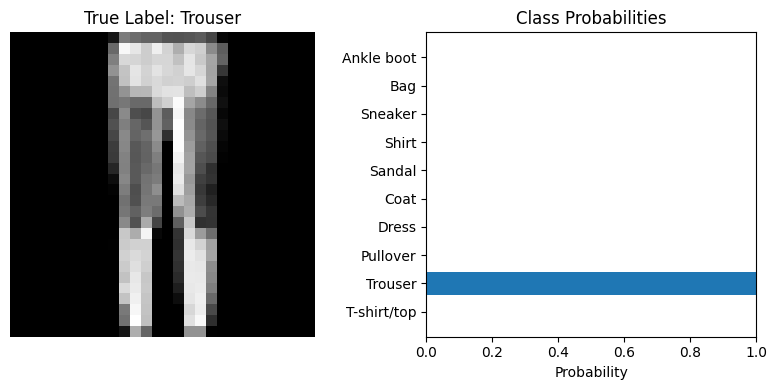

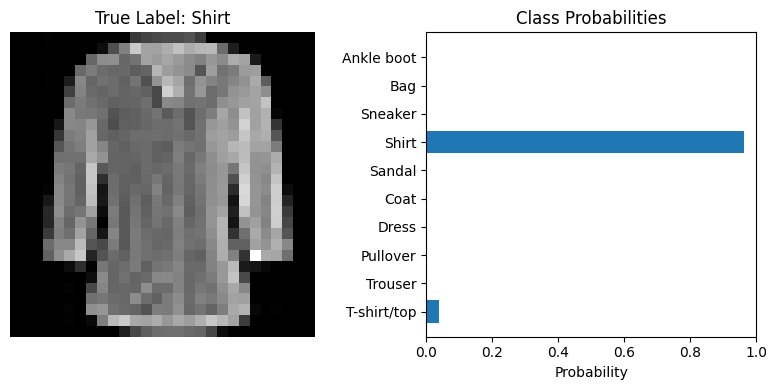

Test Accuracy = 93.7500


In [28]:
print("Test Accuracy = {:.4f}".format(evaluate(model, test_dl)))